In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [79]:
# load runs from experiments
experiments = []
# experiments += ['jun24_cfr_gamut_6'] 
# experiments += ['jun24_cfr_gamut_7']
# experiments += ['jun26_port']
experiments += ['jul19']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 300 runs


In [4]:
def make_combo_specific(evaluation):
    r = dict()
    for k,v in evaluation.samples.items():
        if isinstance(v, dict):
            for k2, v2 in v.items():
                r[f'{k}_{k2}'] = v2
        else:
            r[k] = v
    del r['rewards']

    c_df = pd.DataFrame(r)
    type_columns = [c for c in c_df if 'types_' in c]
    c_df['combo'] = list(map(tuple, c_df[type_columns].values))
    mean_lengths = c_df.groupby('combo')['auction_lengths'].mean()
    ### A given type combo where tie-breaking (non-final) seems to matter
    for v in mean_lengths.values:
        if not v.is_integer() and v < 4:
            print("FOUND YOU", v)
            return True
    return False


In [5]:
records = []

for run in tqdm(runs):
    try:
        checkpoints =  run.equilibriumsolverruncheckpoint_set.all()
        if len(checkpoints) == 0:
            print(f"No checkpoints for {run}!")
            
        for e in checkpoints.all():
            evaluation = e.get_modal_eval()
            record = dict(run=run.name, game=run.game.name, t=e.t, modal_nash_conv=evaluation.nash_conv, walltime=e.walltime, alg=get_algorithm_from_run(run), rewards=evaluation.mean_rewards, improvements=evaluation.player_improvements)

            x = dict(run.config)
            # del x['seed']
            del x['use_wandb']
            del x['solver_type']
            record.update(x)


        ### For Greg: convergence test
#             if run.config['seed'] != 100:
#                 continue
#             try:
#                 game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False, load_policy=True)
#             except Exception as e:
#                 print(f"Skipping run {run.name} because of error {e}")
#                 continue

#             total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test
#             record['total_entropy'] = total_entropy
        ### End


            records.append(record)
    except Exception as e:
        print(f"Run {run} facing error {e}")
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [04:02<00:00,  1.24s/it]


In [6]:
df_time = pd.DataFrame.from_records(records)
# df_time['variant'] = list(map(str,(zip(df_time.sampling_method, df_time.linear_averaging, df_time.regret_matching_plus, df_time.explore_prob, df_time.tremble_prob, df_time.regret_init, df_time.regret_init_strength))))
df_time['variant'] = list(map(str,(zip(df_time.sampling_method, df_time.linear_averaging, df_time.regret_matching_plus))))#, df_time.explore_prob, df_time.tremble_prob, df_time.regret_init, df_time.regret_init_strength))))

In [11]:
df_time['modal_nash_conv'].describe()

count    643.000000
mean       4.998979
std        7.120019
min        0.000000
25%        0.906908
50%        2.666495
75%        5.165683
max       55.894973
Name: modal_nash_conv, dtype: float64

In [ ]:
# plt.figure(figsize=(9,9))

# # Does longer = better?
# dt = df_time.query('~modal_nash_conv.isnull()')
# dt = dt.groupby('variant').filter(lambda grp: len(grp) > 25)
# dt = dt.query('seed == 100 and t > 1_000')
# dt['port'] = dt['run'].str.contains('port')
# # TODO: Limit to same comparison
# dt = dt.groupby(['game', 'variant']).filter(lambda grp: len(grp) == 2)
# # dt.groupby(['variant', 'port'])['modal_nash_conv'].describe()
# dt.pivot(values=['modal_nash_conv'], columns=['port'], index=['variant', 'game']).plot(kind='scatter', x=("modal_nash_conv", False), y=("modal_nash_conv", True))
# plt.axline((0, 0), slope=1)

# # dt.groupby(['variant', 'game'])['modal_nash_conv']

In [ ]:
# df_time.groupby(['sampling_method', 'linear_averaging', 'regret_matching_plus', 'explore_prob'])['modal_nash_conv'].mean()
# Why are 25 rows missing?

# df_time.pivot(['sampling_method', 'linear_averaging', 'regret_matching_plus', 'explore_prob'], index='run', values='modal_nash_conv')


In [ ]:
df_time.query("""variant == "('outcome', True, True, nan, nan, 'straightforward_clock', 100.0)" and t > 1000""")['modal_nash_conv'].describe()

In [ ]:
df_time.groupby('game').size()

In [7]:
num_variants = df_time['variant'].nunique()
df_all = df_time.groupby('game').filter(lambda grp: len(grp) == 9 and grp['modal_nash_conv'].isnull().sum() == 0) # Only look at games where ALL of them had runs and everyone finished NashConv calcs for fairness


In [8]:
df_all.groupby(['variant'])['modal_nash_conv'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max


In [12]:
#### PORTFOLIO LOGIC ####
portfolio = []
algs = df_time['variant'].unique()
df_port = df_all[['variant', 'game', 'modal_nash_conv']].rename(columns={'variant': 'alg', 'game': 'instance', 'modal_nash_conv': 'runtime'})

# Greedy portfolio agg
for i in range(5):
    alg2score = dict()
    for alg in algs:
        new_port = portfolio + [alg]
        score = df_port.query('alg in @new_port').groupby('instance')['runtime'].min().sum()
        alg2score[alg] = score

    best_alg = pd.Series(alg2score).sort_values().idxmin()
    best_score = pd.Series(alg2score).sort_values().min()
    print(i, best_alg, best_score)
    portfolio.append(best_alg)



0 ('outcome', True, True) 0.0
1 ('outcome', True, True) 0.0
2 ('outcome', True, True) 0.0
3 ('outcome', True, True) 0.0
4 ('outcome', True, True) 0.0


In [13]:
df_heatmap = df_all[['variant', 'modal_nash_conv', 'game']].pivot_table(
    values='modal_nash_conv',
    columns=['game'],
    index='variant'
)
df_heatmap_norm=(df_heatmap / df_heatmap.max())
sns.heatmap(df_heatmap_norm, annot=True, cmap='Blues')

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
df_all[['variant', 'modal_nash_conv', 'game']].pivot_table

In [ ]:
z = df_all.query(""" variant == "('outcome', True, True, 0.4)" """)
(z['modal_nash_conv'] / z['rewards'].apply(sum))

In [ ]:
df_time['reward_sum'] = df_time['rewards'].apply(lambda x: sum(x))
df_time['nash_conv_frac'] = df_time['modal_nash_conv'] / df_time['reward_sum']

In [ ]:
df_time.loc[df_time.groupby('run')['t'].idxmax()]

In [ ]:
# TODO: I only want the LAST nashconv, this is dumb
# df.query('~modal_nash_conv.isnull() and alg == "cfr_outcome"').groupby('run')['modal_nash_conv'].describe().sort_values('mean', ascending=False).head(20)

In [ ]:
df.loc[df.groupby('run')['t'].idxmax()].set_index('run')['nash_conv_frac'].sort_values(ascending=False).describe() # Why 69 and not 75?
# In summary, NashConv is usually less than 10%. Hopefully this is also true on a per-player basis. There are a 13 bad cases with > 10%, 7 NaN, and 49 "good"

In [ ]:
# What if you took the "best" t? Can get up to 53 that way... 
(df.groupby('run')['nash_conv_frac'].min() < 0.1).sum()

In [ ]:
plt.figure(figsize=(16, 9))
plt_df = df_time.query('~modal_nash_conv.isnull()').groupby('run').filter(lambda grp: len(grp) > 1).sort_values('t')
for r, sub_df in plt_df.groupby('run'):
    # display(sub_df)
    plt.plot(sub_df['walltime'].values, sub_df['modal_nash_conv'].values, alpha=0.2, color='grey')
plt.ylabel("modal nash conv")
plt.xlabel("walltime")
# plt.legend()
plt.semilogy()
# sns.lineplot(data=plt_df, y='modal_nash_conv', x='t', hue='run', legend=False)

# How many lines are changing downwards? Why is almost no progress ever made after 500K iterations?


In [ ]:
# A different question: What is sum(nash_conv) over walltime? Would have to be careful because of missing data though... Try to quantify improvement of moving to each new update
# Or else a CDF or something of when somethign EVER discovers a good checkpoint, grouped by alg?
# Basically want to know how much time is useful. Sad we didn't run a 0.1 explore to see if that fared better... Maybe look at each alg indepdently?

In [ ]:
plt_df['run'].values

In [ ]:
deltas = df.loc[df.groupby('run')['t'].idxmin()].set_index('run')['modal_nash_conv'] - df.loc[df.groupby('run')['t'].idxmax()].set_index('run')['modal_nash_conv']
deltas[deltas > 0]
# Most of the time, the deltas are very weakly positive. Can definitely move in either direction

In [ ]:
len(e.get_model()._infostates)

In [ ]:
dir(e)

# Analyze runs

In [80]:
# empirical = True
# USE_MODAL = True

records = []
for run in tqdm(runs):
    try:
    
        try:
            game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=True, load_policy=False)
        except Exception as e:
            print(f"Skipping run {run.name} because of error {e}")
            continue

#         if USE_MODAL:
#             evaluation = final_checkpoint.get_modal_eval()
#             # if make_combo_specific(evaluation):
#             #     print(run.name)
#         else:
#             evaluation = final_checkpoint.get_old_eval()
            
            
        # total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test

        # if empirical: 
        #     history_dists = empirical_history_distribution(final_checkpoint.get_old_eval()) # Always use the old eval here
        #     history_entropies = [scipy.stats.entropy(list(history_dists.loc[type_combo].values)) for type_combo in np.unique(history_dists.index.get_level_values(0))]
        # else:
        #     history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
        #     history_entropies = [scipy.stats.entropy(list(history_dists[type_combo].values())) for type_combo in history_dists]

        # try:
        #     # TODO: Broken until you remove "Tremble" agents
        #     _, _, approx_nash_conv = find_best_checkpoint(run)
        # except:
        #     # TODO: Fix bug where this actually happens because your BRs failed to do better and you have an Empirical Nash Conv of 0, very different from NaN
        #     # ev_df = parse_run(run, None)
        #     # display(ev_df)
        #     approx_nash_conv = np.nan

        record = {
            # clock auction params
            'game_name': run.game.name, 
            'potential': run.config.get('potential_function', 'None'),
            'seed': run.config.get('seed'), 
            'run_name': run.name,
            'experiment': run.experiment.name,
            'config': run.get_config_name(),
            't': final_checkpoint.t,

            # CMA knobs
            'information_policy': InformationPolicy(game.auction_params.information_policy).name,
            'activity_policy': ActivityPolicy(game.auction_params.activity_policy).name,
            'undersell_policy': UndersellPolicy(game.auction_params.undersell_policy).name,
            'tiebreaking_policy': TiebreakingPolicy(game.auction_params.tiebreaking_policy).name,
            'grace_rounds': game.auction_params.grace_rounds,
            'risk_aversion': 'risk' in run.game.name, # TODO: actually read this from players
            'spite': 'spite' in run.game.name, # TODO: actually read this from players
            'clock_speed': game.auction_params.increment,
            'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later

            # solver information
            'alg': get_algorithm_from_run(run),
            'walltime': run.walltime(),

            # metrics from eval
            # 'total_entropy': total_entropy,

            # stats about history distribution
            # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
            # 'avg_history_entropy': np.mean(history_entropies),
        } 
        
        evaluation = final_checkpoint.get_modal_eval()
        # evaluation = final_checkpoint.get_old_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan
        
        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan
        
            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan
          
        record.update(**analyze_samples(evaluation.samples, game))

        # Slowwwwww you may want to comment this out when not using it
#         start = time.time()
        # c = final_checkpoint.equilibrium_solver_run.config
        # env_and_policy = ppo_db_checkpoint_loader(final_checkpoint)
        # for player in range(game.num_players()):
        #     env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
        # modal_policy = env_and_policy.make_policy()
        
        # worked, time_taken, hc = time_bounded_run(15, nash_conv, game, modal_policy, restrict_to_heuristics=True)
        # if not worked:
        #     print("Aborted run because time")
        # record['heuristic_conv'] = hc if worked else np.nan
        # record['heuristic_conv_time'] = time_taken
#         print(time.time() - start)

        records.append(record)
    
        nc = record['nash_conv']
        hc = record['heuristic_conv']
        print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

  1%|█▌                                                                                                                                                                                                                                       | 2/300 [00:00<01:20,  3.69it/s]

NashConv = 0.45; HeuristicConv = 0.39
NashConv = 0.19; HeuristicConv = 0.19


  1%|██▎                                                                                                                                                                                                                                      | 3/300 [00:00<01:08,  4.37it/s]

NashConv = 12.39; HeuristicConv = 3.73


  2%|███▉                                                                                                                                                                                                                                     | 5/300 [00:01<01:14,  3.97it/s]

NashConv = 11.18; HeuristicConv = 5.37
NashConv = 0.40; HeuristicConv = 0.40


  2%|████▋                                                                                                                                                                                                                                    | 6/300 [00:01<01:30,  3.26it/s]

NashConv = 0.00; HeuristicConv = 0.00


  3%|██████▏                                                                                                                                                                                                                                  | 8/300 [00:02<01:10,  4.12it/s]

NashConv = 24.15; HeuristicConv = 10.02
NashConv = 13.85; HeuristicConv = 5.23


  3%|███████▋                                                                                                                                                                                                                                | 10/300 [00:02<01:08,  4.26it/s]

NashConv = 0.00; HeuristicConv = 0.00
NashConv = 3.44; HeuristicConv = 3.44


  4%|█████████▎                                                                                                                                                                                                                              | 12/300 [00:03<01:12,  3.97it/s]

NashConv = 1.69; HeuristicConv = 1.69
NashConv = 14.14; HeuristicConv = 12.01


  4%|██████████                                                                                                                                                                                                                              | 13/300 [00:03<01:00,  4.78it/s]

NashConv = 0.05; HeuristicConv = 0.05


  5%|███████████▌                                                                                                                                                                                                                            | 15/300 [00:03<01:03,  4.47it/s]

NashConv = 3.34; HeuristicConv = 0.20
NashConv = 5.79; HeuristicConv = 3.07


  5%|████████████▎                                                                                                                                                                                                                           | 16/300 [00:06<03:56,  1.20it/s]

NashConv = nan; HeuristicConv = 24.22


  6%|█████████████▉                                                                                                                                                                                                                          | 18/300 [00:06<02:27,  1.91it/s]

NashConv = 3.23; HeuristicConv = 3.23
NashConv = 0.58; HeuristicConv = 0.06


  6%|██████████████▋                                                                                                                                                                                                                         | 19/300 [00:06<02:02,  2.30it/s]

NashConv = 26.73; HeuristicConv = 26.73


  7%|████████████████▏                                                                                                                                                                                                                       | 21/300 [00:09<03:23,  1.37it/s]

NashConv = nan; HeuristicConv = 26.62
NashConv = 0.14; HeuristicConv = 0.14


  7%|█████████████████                                                                                                                                                                                                                       | 22/300 [00:09<02:55,  1.58it/s]

NashConv = 0.48; HeuristicConv = 0.00


  8%|█████████████████▊                                                                                                                                                                                                                      | 23/300 [00:09<02:21,  1.96it/s]

NashConv = 31.35; HeuristicConv = 21.85


  8%|██████████████████▌                                                                                                                                                                                                                     | 24/300 [00:11<04:19,  1.07it/s]

NashConv = nan; HeuristicConv = 17.02


  9%|████████████████████                                                                                                                                                                                                                    | 26/300 [00:12<02:38,  1.73it/s]

NashConv = 0.00; HeuristicConv = 0.00
NashConv = 0.05; HeuristicConv = 0.05


  9%|████████████████████▉                                                                                                                                                                                                                   | 27/300 [00:12<02:32,  1.79it/s]

NashConv = nan; HeuristicConv = 18.60


 10%|██████████████████████▍                                                                                                                                                                                                                 | 29/300 [00:14<03:01,  1.49it/s]

NashConv = 46.84; HeuristicConv = 36.45
NashConv = 1.39; HeuristicConv = 0.85


 10%|███████████████████████▏                                                                                                                                                                                                                | 30/300 [00:14<02:16,  1.98it/s]

NashConv = 9.07; HeuristicConv = 0.00


 10%|███████████████████████▉                                                                                                                                                                                                                | 31/300 [00:15<02:42,  1.65it/s]

NashConv = 20.27; HeuristicConv = 11.82


 11%|████████████████████████▋                                                                                                                                                                                                               | 32/300 [00:17<03:52,  1.15it/s]

NashConv = nan; HeuristicConv = 14.71


 11%|██████████████████████████▎                                                                                                                                                                                                             | 34/300 [00:17<02:28,  1.79it/s]

NashConv = 22.41; HeuristicConv = 1.53
NashConv = 10.36; HeuristicConv = 1.53


 12%|███████████████████████████                                                                                                                                                                                                             | 35/300 [00:18<02:53,  1.53it/s]

NashConv = nan; HeuristicConv = 12.72


 12%|████████████████████████████▌                                                                                                                                                                                                           | 37/300 [00:20<03:16,  1.34it/s]

NashConv = nan; HeuristicConv = 27.94
NashConv = 2.22; HeuristicConv = 0.00


 13%|█████████████████████████████▍                                                                                                                                                                                                          | 38/300 [00:20<02:27,  1.78it/s]

NashConv = 1.18; HeuristicConv = 1.18


 13%|██████████████████████████████▉                                                                                                                                                                                                         | 40/300 [00:21<01:59,  2.17it/s]

NashConv = 24.68; HeuristicConv = 9.04
NashConv = 0.33; HeuristicConv = 0.03


 14%|███████████████████████████████▋                                                                                                                                                                                                        | 41/300 [00:21<01:32,  2.81it/s]

NashConv = 0.16; HeuristicConv = 0.11


 14%|█████████████████████████████████▎                                                                                                                                                                                                      | 43/300 [00:22<01:15,  3.41it/s]

NashConv = 0.87; HeuristicConv = 0.15
NashConv = 0.66; HeuristicConv = 0.66


 15%|██████████████████████████████████▊                                                                                                                                                                                                     | 45/300 [00:22<01:07,  3.79it/s]

NashConv = 1.11; HeuristicConv = 1.06
NashConv = 1.68; HeuristicConv = 1.68


 15%|███████████████████████████████████▌                                                                                                                                                                                                    | 46/300 [00:22<00:55,  4.57it/s]

NashConv = 0.26; HeuristicConv = 0.26


 16%|█████████████████████████████████████                                                                                                                                                                                                   | 48/300 [00:23<00:59,  4.20it/s]

NashConv = 4.60; HeuristicConv = 4.60
NashConv = 1.47; HeuristicConv = 0.07


 16%|█████████████████████████████████████▉                                                                                                                                                                                                  | 49/300 [00:23<00:50,  5.00it/s]

NashConv = 0.08; HeuristicConv = 0.08


 17%|███████████████████████████████████████▍                                                                                                                                                                                                | 51/300 [00:24<00:56,  4.42it/s]

NashConv = 0.11; HeuristicConv = 0.11
NashConv = 2.57; HeuristicConv = 1.55


 18%|████████████████████████████████████████▉                                                                                                                                                                                               | 53/300 [00:24<00:57,  4.30it/s]

NashConv = 15.61; HeuristicConv = 11.97
NashConv = 0.10; HeuristicConv = 0.10


 18%|█████████████████████████████████████████▊                                                                                                                                                                                              | 54/300 [00:24<00:48,  5.12it/s]

NashConv = 0.00; HeuristicConv = 0.00


 19%|███████████████████████████████████████████▎                                                                                                                                                                                            | 56/300 [00:25<00:52,  4.64it/s]

NashConv = 2.20; HeuristicConv = 2.20
NashConv = 3.54; HeuristicConv = 3.54


 19%|████████████████████████████████████████████                                                                                                                                                                                            | 57/300 [00:25<00:44,  5.45it/s]

NashConv = 0.09; HeuristicConv = 0.09


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                          | 59/300 [00:25<00:49,  4.86it/s]

NashConv = 0.11; HeuristicConv = 0.11
NashConv = 0.00; HeuristicConv = 0.00


 20%|███████████████████████████████████████████████▏                                                                                                                                                                                        | 61/300 [00:26<00:52,  4.57it/s]

NashConv = 0.09; HeuristicConv = 0.09
NashConv = 1.08; HeuristicConv = 0.05


 21%|███████████████████████████████████████████████▉                                                                                                                                                                                        | 62/300 [00:26<00:55,  4.29it/s]

NashConv = nan; HeuristicConv = 5.91


 21%|█████████████████████████████████████████████████▍                                                                                                                                                                                      | 64/300 [00:27<00:55,  4.24it/s]

NashConv = 0.71; HeuristicConv = 0.21
NashConv = 1.08; HeuristicConv = 0.05


 22%|██████████████████████████████████████████████████▎                                                                                                                                                                                     | 65/300 [00:27<00:47,  4.90it/s]

NashConv = 0.17; HeuristicConv = 0.15


 22%|███████████████████████████████████████████████████                                                                                                                                                                                     | 66/300 [00:27<01:02,  3.77it/s]

NashConv = 0.05; HeuristicConv = 0.05


 23%|████████████████████████████████████████████████████▌                                                                                                                                                                                   | 68/300 [00:28<00:51,  4.51it/s]

NashConv = nan; HeuristicConv = 5.73
NashConv = 0.10; HeuristicConv = 0.10


 23%|█████████████████████████████████████████████████████▎                                                                                                                                                                                  | 69/300 [00:28<01:03,  3.63it/s]

NashConv = 0.05; HeuristicConv = 0.05


 23%|██████████████████████████████████████████████████████▏                                                                                                                                                                                 | 70/300 [00:28<01:05,  3.49it/s]

NashConv = 10.47; HeuristicConv = 1.84


 24%|███████████████████████████████████████████████████████▋                                                                                                                                                                                | 72/300 [00:29<00:58,  3.88it/s]

NashConv = 0.24; HeuristicConv = 0.24
NashConv = 0.34; HeuristicConv = 0.14


 24%|████████████████████████████████████████████████████████▍                                                                                                                                                                               | 73/300 [00:29<01:13,  3.09it/s]

NashConv = 21.54; HeuristicConv = 18.49


 25%|██████████████████████████████████████████████████████████                                                                                                                                                                              | 75/300 [00:30<01:02,  3.63it/s]

NashConv = 0.23; HeuristicConv = 0.23
NashConv = 0.10; HeuristicConv = 0.10


 25%|██████████████████████████████████████████████████████████▊                                                                                                                                                                             | 76/300 [00:30<00:50,  4.47it/s]

NashConv = 0.00; HeuristicConv = 0.00


 26%|████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 78/300 [00:30<00:50,  4.44it/s]

NashConv = 6.13; HeuristicConv = 6.13
NashConv = 3.23; HeuristicConv = 3.23


 27%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 80/300 [00:31<00:51,  4.28it/s]

NashConv = 0.00; HeuristicConv = 0.00
NashConv = 0.00; HeuristicConv = 0.00


 27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 81/300 [00:31<00:42,  5.10it/s]

NashConv = 0.00; HeuristicConv = 0.00


 28%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 83/300 [00:32<00:46,  4.69it/s]

NashConv = 0.62; HeuristicConv = 0.62
NashConv = 0.11; HeuristicConv = 0.11


 28%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 84/300 [00:32<00:39,  5.48it/s]

NashConv = 3.64; HeuristicConv = 0.82


 29%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 86/300 [00:32<00:44,  4.86it/s]

NashConv = 0.01; HeuristicConv = 0.01
NashConv = 1.18; HeuristicConv = 0.09


 29%|████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 88/300 [00:33<00:46,  4.51it/s]

NashConv = 5.15; HeuristicConv = 4.08
NashConv = 1.45; HeuristicConv = 1.45


 30%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 89/300 [00:33<00:39,  5.34it/s]

NashConv = 0.41; HeuristicConv = 0.00


 30%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 91/300 [00:33<00:43,  4.76it/s]

NashConv = 6.29; HeuristicConv = 6.29
NashConv = 0.01; HeuristicConv = 0.00


 31%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 92/300 [00:33<00:37,  5.58it/s]

NashConv = 1.00; HeuristicConv = 0.05


 31%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 94/300 [00:34<00:43,  4.75it/s]

NashConv = 0.20; HeuristicConv = 0.19
NashConv = 9.93; HeuristicConv = 9.06


 32%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 96/300 [00:35<00:45,  4.44it/s]

NashConv = 0.05; HeuristicConv = 0.05
NashConv = 0.60; HeuristicConv = 0.08


 32%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 97/300 [00:35<00:38,  5.23it/s]

NashConv = 1.99; HeuristicConv = 1.99


 33%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 99/300 [00:35<00:43,  4.62it/s]

NashConv = 1.08; HeuristicConv = 0.05
NashConv = 0.74; HeuristicConv = 0.24


 34%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 101/300 [00:36<00:45,  4.42it/s]

NashConv = 1.05; HeuristicConv = 0.07
NashConv = 0.97; HeuristicConv = 0.05


 34%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 102/300 [00:36<00:37,  5.23it/s]

NashConv = 0.09; HeuristicConv = 0.09


 35%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 104/300 [00:36<00:42,  4.58it/s]

NashConv = 1.08; HeuristicConv = 0.07
NashConv = 0.27; HeuristicConv = 0.26


 35%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 105/300 [00:36<00:36,  5.41it/s]

NashConv = 3.44; HeuristicConv = 3.44


 36%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 107/300 [00:37<00:40,  4.76it/s]

NashConv = 5.04; HeuristicConv = 1.11
NashConv = 0.26; HeuristicConv = 0.26


 36%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 109/300 [00:37<00:42,  4.49it/s]

NashConv = 4.85; HeuristicConv = 4.85
NashConv = 5.89; HeuristicConv = 1.28


 37%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 110/300 [00:38<00:35,  5.30it/s]

NashConv = 1.15; HeuristicConv = 0.00


 37%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 111/300 [00:38<00:47,  3.94it/s]

NashConv = 5.74; HeuristicConv = 5.74


 38%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 113/300 [00:40<02:02,  1.52it/s]

NashConv = nan; HeuristicConv = 13.76
NashConv = 5.73; HeuristicConv = 0.94


 38%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 114/300 [00:42<02:45,  1.13it/s]

NashConv = nan; HeuristicConv = 16.40


 38%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 115/300 [00:44<03:57,  1.29s/it]

NashConv = nan; HeuristicConv = 12.09


 39%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 116/300 [00:46<04:22,  1.42s/it]

NashConv = nan; HeuristicConv = 5.35


 39%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 118/300 [00:47<03:05,  1.02s/it]

NashConv = nan; HeuristicConv = 17.14
NashConv = 0.96; HeuristicConv = 0.03


 40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 120/300 [00:49<02:24,  1.25it/s]

NashConv = nan; HeuristicConv = 9.47
NashConv = 0.06; HeuristicConv = 0.06


 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 121/300 [00:49<01:46,  1.67it/s]

NashConv = nan; HeuristicConv = 3.57


 41%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 123/300 [00:49<01:13,  2.42it/s]

NashConv = nan; HeuristicConv = 1.97
NashConv = 0.17; HeuristicConv = 0.16


 41%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 124/300 [00:49<00:56,  3.13it/s]

NashConv = 0.11; HeuristicConv = 0.11


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 126/300 [00:50<00:47,  3.66it/s]

NashConv = 3.73; HeuristicConv = 3.73
NashConv = 0.15; HeuristicConv = 0.15


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 127/300 [00:50<00:53,  3.21it/s]

NashConv = 4.43; HeuristicConv = 0.20


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 129/300 [00:52<01:09,  2.48it/s]

NashConv = nan; HeuristicConv = 2.59
NashConv = 0.17; HeuristicConv = 0.17


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 130/300 [00:52<01:11,  2.38it/s]

NashConv = 2.15; HeuristicConv = 0.16


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 132/300 [00:52<00:52,  3.17it/s]

NashConv = 15.41; HeuristicConv = 2.67
NashConv = 8.04; HeuristicConv = 0.89


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 134/300 [00:53<00:49,  3.33it/s]

NashConv = 3.19; HeuristicConv = 0.07
NashConv = 0.79; HeuristicConv = 0.34


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 135/300 [00:53<00:40,  4.10it/s]

NashConv = 6.13; HeuristicConv = 4.43


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 137/300 [00:54<00:40,  4.02it/s]

NashConv = 0.09; HeuristicConv = 0.09
NashConv = 3.13; HeuristicConv = 0.37


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 139/300 [00:54<00:38,  4.16it/s]

NashConv = 1.00; HeuristicConv = 0.05
NashConv = 6.64; HeuristicConv = 3.91


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 140/300 [00:55<00:48,  3.29it/s]

NashConv = nan; HeuristicConv = 5.11


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 142/300 [00:55<00:42,  3.76it/s]

NashConv = 0.00; HeuristicConv = 0.00
NashConv = 3.21; HeuristicConv = 3.21


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 143/300 [00:56<00:42,  3.71it/s]

NashConv = 33.06; HeuristicConv = 12.02


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 145/300 [00:56<00:38,  4.01it/s]

NashConv = 0.00; HeuristicConv = 0.00
NashConv = 3.77; HeuristicConv = 3.77


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 147/300 [00:57<00:41,  3.64it/s]

NashConv = nan; HeuristicConv = 5.98
NashConv = 0.00; HeuristicConv = 0.00


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 148/300 [00:57<00:33,  4.48it/s]

NashConv = 3.43; HeuristicConv = 3.43


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 150/300 [00:57<00:37,  3.96it/s]

NashConv = 15.63; HeuristicConv = 10.45
NashConv = 0.77; HeuristicConv = 0.77
NashConv = 3.43; HeuristicConv = 3.43


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 153/300 [00:58<00:31,  4.61it/s]

NashConv = 7.69; HeuristicConv = 2.55
NashConv = 1.32; HeuristicConv = 1.32


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 154/300 [00:59<01:01,  2.38it/s]

NashConv = nan; HeuristicConv = 2.42


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 155/300 [01:00<01:34,  1.53it/s]

NashConv = nan; HeuristicConv = 5.43


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 156/300 [01:01<01:48,  1.33it/s]

NashConv = nan; HeuristicConv = 9.71


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 158/300 [01:02<01:11,  2.00it/s]

NashConv = 2.59; HeuristicConv = 0.41
NashConv = 1.69; HeuristicConv = 1.69


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 159/300 [01:02<01:14,  1.88it/s]

NashConv = nan; HeuristicConv = 11.79


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 161/300 [01:03<00:53,  2.60it/s]

NashConv = 0.55; HeuristicConv = 0.03
NashConv = 5.46; HeuristicConv = 1.48


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 163/300 [01:04<00:57,  2.38it/s]

NashConv = nan; HeuristicConv = 3.14
NashConv = 0.64; HeuristicConv = 0.00


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 164/300 [01:04<00:44,  3.03it/s]

NashConv = 4.24; HeuristicConv = 1.72


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 165/300 [01:05<01:09,  1.94it/s]

NashConv = nan; HeuristicConv = 14.56


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 166/300 [01:06<01:31,  1.46it/s]

NashConv = nan; HeuristicConv = 3.19


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 168/300 [01:07<01:00,  2.17it/s]

NashConv = 8.05; HeuristicConv = 1.31
NashConv = 10.41; HeuristicConv = 4.97


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 169/300 [01:08<01:23,  1.57it/s]

NashConv = nan; HeuristicConv = 4.55


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 171/300 [01:08<00:57,  2.25it/s]

NashConv = 2.26; HeuristicConv = 2.14
NashConv = 9.17; HeuristicConv = 9.17


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 172/300 [01:09<00:44,  2.88it/s]

NashConv = 14.29; HeuristicConv = 11.87


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 174/300 [01:09<00:36,  3.41it/s]

NashConv = 6.33; HeuristicConv = 6.33
NashConv = 12.70; HeuristicConv = 11.52


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 176/300 [01:10<00:33,  3.73it/s]

NashConv = 8.73; HeuristicConv = 2.04
NashConv = 3.57; HeuristicConv = 3.57


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 177/300 [01:10<00:27,  4.53it/s]

NashConv = 13.77; HeuristicConv = 6.00


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 179/300 [01:10<00:27,  4.33it/s]

NashConv = 0.71; HeuristicConv = 0.71
NashConv = nan; HeuristicConv = 0.85


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 180/300 [01:10<00:23,  5.02it/s]

NashConv = 10.83; HeuristicConv = 10.00


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 182/300 [01:11<00:25,  4.60it/s]

NashConv = 2.22; HeuristicConv = 2.22
NashConv = 2.70; HeuristicConv = 2.09


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 184/300 [01:11<00:27,  4.15it/s]

NashConv = 13.36; HeuristicConv = 9.10
NashConv = nan; HeuristicConv = 0.00


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 185/300 [01:12<00:23,  4.96it/s]

NashConv = 1.13; HeuristicConv = 1.13


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 187/300 [01:12<00:26,  4.25it/s]

NashConv = nan; HeuristicConv = 0.00
NashConv = 0.35; HeuristicConv = 0.00


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 188/300 [01:12<00:21,  5.12it/s]

NashConv = 2.14; HeuristicConv = 1.34


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 190/300 [01:13<00:24,  4.54it/s]

NashConv = nan; HeuristicConv = 0.00
NashConv = 0.01; HeuristicConv = 0.01


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 192/300 [01:13<00:25,  4.20it/s]

NashConv = 3.46; HeuristicConv = 0.00
NashConv = nan; HeuristicConv = 0.00
NashConv = 5.70; HeuristicConv = 0.01


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 195/300 [01:14<00:22,  4.58it/s]

NashConv = 1.76; HeuristicConv = 1.76
NashConv = 5.59; HeuristicConv = 2.71


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 196/300 [01:14<00:20,  5.04it/s]

NashConv = nan; HeuristicConv = 0.00


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 198/300 [01:15<00:23,  4.39it/s]

NashConv = 0.00; HeuristicConv = 0.00
NashConv = 5.16; HeuristicConv = 0.59


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 199/300 [01:15<00:19,  5.13it/s]

NashConv = 4.37; HeuristicConv = 0.00


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 201/300 [01:15<00:21,  4.60it/s]

NashConv = 1.66; HeuristicConv = 1.66
NashConv = 0.07; HeuristicConv = 0.07


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 202/300 [01:15<00:18,  5.43it/s]

NashConv = 2.81; HeuristicConv = 0.15


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 203/300 [01:16<00:25,  3.87it/s]

NashConv = 4.05; HeuristicConv = 2.36


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 204/300 [01:17<00:41,  2.32it/s]

NashConv = nan; HeuristicConv = 2.17


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 206/300 [01:17<00:31,  2.98it/s]

NashConv = 1.98; HeuristicConv = 0.29
NashConv = 2.12; HeuristicConv = 1.97


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 207/300 [01:18<00:46,  1.99it/s]

NashConv = nan; HeuristicConv = 6.71


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 209/300 [01:21<01:15,  1.21it/s]

NashConv = nan; HeuristicConv = 9.53
NashConv = 21.66; HeuristicConv = 21.66


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 210/300 [01:22<01:15,  1.19it/s]

NashConv = nan; HeuristicConv = 12.66


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 212/300 [01:23<01:08,  1.29it/s]

NashConv = nan; HeuristicConv = 21.92
NashConv = 2.30; HeuristicConv = 2.30


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 213/300 [01:24<00:57,  1.50it/s]

NashConv = 18.36; HeuristicConv = 13.78


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 215/300 [01:25<00:47,  1.79it/s]

NashConv = nan; HeuristicConv = 8.50
NashConv = 4.74; HeuristicConv = 2.23


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 216/300 [01:26<00:50,  1.67it/s]

NashConv = 22.73; HeuristicConv = 15.57


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 218/300 [01:26<00:35,  2.33it/s]

NashConv = nan; HeuristicConv = 6.54
NashConv = nan; HeuristicConv = 0.73


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 220/300 [01:27<00:32,  2.43it/s]

NashConv = nan; HeuristicConv = 7.73
NashConv = 0.00; HeuristicConv = 0.00


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 221/300 [01:27<00:25,  3.10it/s]

NashConv = 0.06; HeuristicConv = 0.06


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 223/300 [01:29<00:36,  2.12it/s]

NashConv = nan; HeuristicConv = 0.11
NashConv = 0.00; HeuristicConv = 0.00


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 224/300 [01:29<00:27,  2.75it/s]

NashConv = 0.07; HeuristicConv = 0.07


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 226/300 [01:30<00:37,  2.00it/s]

NashConv = nan; HeuristicConv = 6.66
NashConv = 14.47; HeuristicConv = 11.23


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 227/300 [01:31<00:35,  2.08it/s]

NashConv = 6.39; HeuristicConv = 2.57


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 229/300 [01:32<00:35,  1.99it/s]

NashConv = nan; HeuristicConv = 5.60
NashConv = 12.70; HeuristicConv = 11.52


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 230/300 [01:32<00:32,  2.12it/s]

NashConv = 1.30; HeuristicConv = 1.30


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 231/300 [01:33<00:42,  1.61it/s]

NashConv = nan; HeuristicConv = 21.13


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 233/300 [01:34<00:34,  1.96it/s]

NashConv = nan; HeuristicConv = 0.15
NashConv = 2.26; HeuristicConv = 2.14


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 234/300 [01:35<00:40,  1.64it/s]

NashConv = nan; HeuristicConv = 29.78


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 235/300 [01:36<00:54,  1.20it/s]

NashConv = nan; HeuristicConv = 9.65


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 236/300 [01:37<00:52,  1.21it/s]

NashConv = nan; HeuristicConv = 12.98


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 237/300 [01:38<00:52,  1.19it/s]

NashConv = 24.03; HeuristicConv = 10.69


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 238/300 [01:39<00:50,  1.22it/s]

NashConv = nan; HeuristicConv = 5.55


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 239/300 [01:40<00:51,  1.17it/s]

NashConv = nan; HeuristicConv = 12.72


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 240/300 [01:40<00:43,  1.37it/s]

NashConv = 3.18; HeuristicConv = 2.29


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 242/300 [01:41<00:28,  2.01it/s]

NashConv = nan; HeuristicConv = 5.11
NashConv = 6.21; HeuristicConv = 3.30


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 244/300 [01:41<00:21,  2.67it/s]

NashConv = 0.19; HeuristicConv = 0.19
NashConv = 1.22; HeuristicConv = 0.11


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 246/300 [01:42<00:17,  3.10it/s]

NashConv = 9.58; HeuristicConv = 3.69
NashConv = 5.48; HeuristicConv = 0.50


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 248/300 [01:43<00:14,  3.53it/s]

NashConv = 0.92; HeuristicConv = 0.42
NashConv = 3.92; HeuristicConv = 2.23


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 249/300 [01:43<00:12,  4.20it/s]

NashConv = 0.29; HeuristicConv = 0.28


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 251/300 [01:43<00:11,  4.27it/s]

NashConv = 0.00; HeuristicConv = 0.00
NashConv = 3.10; HeuristicConv = 2.06


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 252/300 [01:43<00:09,  4.98it/s]

NashConv = 1.52; HeuristicConv = 0.16


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 254/300 [01:44<00:10,  4.44it/s]

NashConv = 0.46; HeuristicConv = 0.00
NashConv = nan; HeuristicConv = 1.52


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 255/300 [01:44<00:08,  5.10it/s]

NashConv = 4.51; HeuristicConv = 0.17


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 257/300 [01:45<00:09,  4.48it/s]

NashConv = 2.91; HeuristicConv = 1.64
NashConv = 10.36; HeuristicConv = 1.10


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 259/300 [01:45<00:09,  4.27it/s]

NashConv = 1.19; HeuristicConv = 0.04
NashConv = 3.48; HeuristicConv = 0.07


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 260/300 [01:45<00:07,  5.00it/s]

NashConv = 6.35; HeuristicConv = 3.57


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 262/300 [01:46<00:08,  4.28it/s]

NashConv = 3.24; HeuristicConv = 0.12
NashConv = 0.01; HeuristicConv = 0.01


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 264/300 [01:46<00:09,  3.96it/s]

NashConv = 8.78; HeuristicConv = 5.35
NashConv = 4.61; HeuristicConv = 0.07


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 265/300 [01:47<00:07,  4.76it/s]

NashConv = 2.03; HeuristicConv = 0.00


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 267/300 [01:47<00:07,  4.38it/s]

NashConv = 5.68; HeuristicConv = 0.82
NashConv = 1.49; HeuristicConv = 0.06


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 268/300 [01:47<00:06,  4.99it/s]

NashConv = 17.66; HeuristicConv = 1.48


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 270/300 [01:48<00:06,  4.57it/s]

NashConv = 0.02; HeuristicConv = 0.02
NashConv = 0.91; HeuristicConv = 0.47


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 271/300 [01:48<00:05,  5.16it/s]

NashConv = 2.82; HeuristicConv = 2.70


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 273/300 [01:48<00:06,  4.47it/s]

NashConv = 0.75; HeuristicConv = 0.06
NashConv = 2.13; HeuristicConv = 0.59


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 275/300 [01:49<00:06,  4.15it/s]

NashConv = 5.42; HeuristicConv = 0.20
NashConv = 2.30; HeuristicConv = 0.32


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 276/300 [01:49<00:07,  3.24it/s]

NashConv = 22.27; HeuristicConv = 8.85


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 278/300 [01:50<00:05,  3.68it/s]

NashConv = 1.58; HeuristicConv = 0.63
NashConv = 0.35; HeuristicConv = 0.35


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 280/300 [01:51<00:06,  3.02it/s]

NashConv = 15.48; HeuristicConv = 5.78
NashConv = 1.85; HeuristicConv = 0.85


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 281/300 [01:51<00:05,  3.75it/s]

NashConv = 0.26; HeuristicConv = 0.26


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 283/300 [01:52<00:05,  3.07it/s]

NashConv = nan; HeuristicConv = 5.74
NashConv = 2.04; HeuristicConv = 0.07


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 284/300 [01:52<00:04,  3.85it/s]

NashConv = 0.00; HeuristicConv = 0.00


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 286/300 [01:53<00:04,  3.46it/s]

NashConv = 23.81; HeuristicConv = 17.52
NashConv = 0.04; HeuristicConv = 0.04


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 287/300 [01:53<00:04,  3.01it/s]

NashConv = 0.00; HeuristicConv = 0.00


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 289/300 [01:53<00:02,  3.95it/s]

NashConv = 25.34; HeuristicConv = 20.46
NashConv = 0.00; HeuristicConv = 0.00


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 290/300 [01:54<00:03,  3.27it/s]

NashConv = 0.18; HeuristicConv = 0.18


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 292/300 [01:54<00:02,  3.92it/s]

NashConv = 37.68; HeuristicConv = 27.13
NashConv = 0.07; HeuristicConv = 0.01


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 293/300 [01:55<00:02,  3.27it/s]

NashConv = 1.51; HeuristicConv = 0.26


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 294/300 [01:55<00:01,  3.61it/s]

NashConv = nan; HeuristicConv = 2.75


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 296/300 [01:56<00:01,  3.86it/s]

NashConv = 3.21; HeuristicConv = 3.21
NashConv = 2.24; HeuristicConv = 0.00


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 297/300 [01:56<00:00,  4.03it/s]

NashConv = nan; HeuristicConv = 7.12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 299/300 [01:56<00:00,  4.07it/s]

NashConv = 0.15; HeuristicConv = 0.15
NashConv = 2.12; HeuristicConv = 0.00


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:57<00:00,  2.56it/s]

NashConv = nan; HeuristicConv = 9.25
300


In [53]:
df = pd.DataFrame.from_records(records)
# df['imperfect'] = df['game_name'].str.contains('imperfect')


In [125]:
df['rule_set'] = df.apply(lambda row: row.game_name.split(row.base_game_name)[1][1:-5], axis=1)

In [72]:
def describe_nc(df):
    print("NC")
    print(df['nash_conv'].describe())
    
    print("HC when NC is not null")
    print(df.query('~nash_conv.isnull()')['heuristic_conv'].describe())
    
    print("HC when NC is null")
    print(df.query('nash_conv.isnull()')['heuristic_conv'].describe())
    
    print("HC overall")
    print(df['heuristic_conv'].describe())
    print()
    
    


# Overall
print("OVERALL")
describe_nc(df)

# Did biasing towards heuristics help?
no_bias = df.query('config.str.contains("cfr_port_2_no_ext")')
print("NO BIAS")
describe_nc(no_bias)

yes_bias = df.query('config.str.contains("cfr_port_3")')
print("YES BIAS")
describe_nc(yes_bias)


OVERALL
NC
count    241.000000
mean       4.740662
std        7.304960
min        0.000000
25%        0.258872
50%        1.984764
75%        5.587223
max       46.835902
Name: nash_conv, dtype: float64
HC when NC is not null
count    241.000000
mean       2.651499
std        5.106783
min        0.000000
25%        0.066299
50%        0.391734
75%        2.700261
max       36.445188
Name: heuristic_conv, dtype: float64
HC when NC is null
count    59.000000
mean      8.725649
std       7.558217
min       0.000000
25%       2.943576
50%       6.536257
75%      12.721134
max      29.780633
Name: heuristic_conv, dtype: float64
HC overall
count    300.000000
mean       3.846082
std        6.153302
min        0.000000
25%        0.081820
50%        1.105157
75%        5.110331
max       36.445188
Name: heuristic_conv, dtype: float64

NO BIAS
NC
count    121.000000
mean       5.042322
std        7.695802
min        0.000000
25%        0.196632
50%        2.134533
75%        5.481078
max      

In [9]:
df.heuristic_conv.describe()

count    195.000000
mean       3.329215
std        5.492855
min        0.000000
25%        0.364938
50%        1.022989
75%        3.769000
max       32.920099
Name: heuristic_conv, dtype: float64

Text(0, 0.5, 'HeuristicConv')

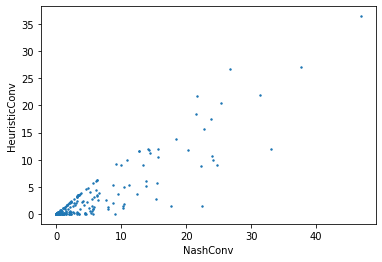

In [73]:
plt.scatter(
    df.nash_conv.values,
    df.heuristic_conv.values,
    s=2
)
plt.xlabel('NashConv')
plt.ylabel('HeuristicConv')

In [56]:
df['DifferenceConv'] = df.nash_conv - df.heuristic_conv
df.sort_values('DifferenceConv').dropna().tail().run_name.values

array(['jun26_jun26_1_grace_period-cfr_port_3outcome_lin_avg-101',
       'jun26_jun26_3_no_activity-cfr_port_3outcome_lin_avg-100',
       'jun26_jun26_1_base-cfr_port_2_no_extoutcome_lin_avg_plus-100',
       'jun26_jun26_1_base-cfr_port_3outcome_lin_avg_plus-102',
       'jun26_jun26_0_no_activity-cfr_port_3outcome_lin_avg-100'],
      dtype=object)

In [29]:
df.sort_values('heuristic_conv').dropna().tail().run_name.values

array(['jun26_jun26_1_base-cfr_port_2outcome_lin_avg-101',
       'jun26_jun26_2_no_activity-cfr_port_2_no_extoutcome_lin_avg-100',
       'jun26_jun26_0_no_activity-cfr_port_2_no_extoutcome_lin_avg-101',
       'jun26_jun26_0_no_activity-cfr_port_2_no_extoutcome_lin_avg-102',
       'jun26_jun26_0_no_activity-cfr_port_2_no_extoutcome_lin_avg-100'],
      dtype=object)

In [20]:
df.query('~nash_conv.isnull()').variant.value_counts()

variant
('SHOW_DEMAND', 0.45, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)    45
('SHOW_DEMAND', 0.6, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)     45
('SHOW_DEMAND', 0.3, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)     41
('SHOW_DEMAND', 0.3, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 2)     22
('SHOW_DEMAND', 0.3, 'OFF', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)     7
Name: count, dtype: int64

In [21]:
df.query('~heuristic_conv.isnull()').variant.value_counts()

variant
('SHOW_DEMAND', 0.3, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)     45
('SHOW_DEMAND', 0.45, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)    45
('SHOW_DEMAND', 0.6, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)     45
('SHOW_DEMAND', 0.3, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 2)     30
('SHOW_DEMAND', 0.3, 'OFF', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)    26
Name: count, dtype: int64

In [35]:
df.query('nash_conv.isnull()').variant.value_counts()

variant
('SHOW_DEMAND', 0.3, 'OFF', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)    23
('SHOW_DEMAND', 0.3, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 2)      8
('SHOW_DEMAND', 0.3, 'ON', 'UNDERSELL', 'DROP_BY_PLAYER', False, 1)      4
Name: count, dtype: int64

In [59]:
# TODO: Maybe actually make this readable?
df['variant'] = list(map(str,(zip(df.information_policy, df.clock_speed, df.activity_policy, df.undersell_policy, df.tiebreaking_policy, df.risk_aversion, df.grace_rounds))))
palette = dict()

colors = ['red', 'blue', 'magenta', 'green', 'orange']

for i, v in enumerate(df['variant'].unique()):
    palette[v] = colors[i]

In [127]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df

In [128]:
### Remove bad entries
good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh}')
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
len(df), len(df_plt)

# (df.groupby('game_name').size() - df_plt.groupby('game_name').size()).sort_values()

(300, 216)

In [129]:
# df.query('activity_policy == "OFF"')['nash_conv_frac']
# df.query('undersell_policy == "UNDERSELL" and information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 ')[['t', 'nash_conv', 'nash_conv_frac']]

114


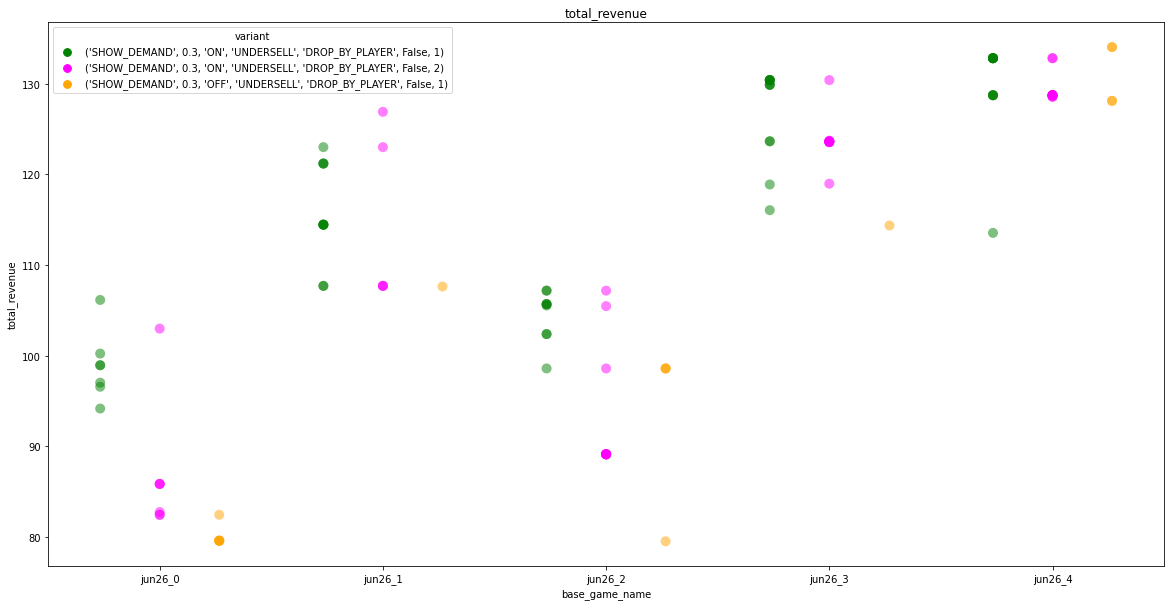

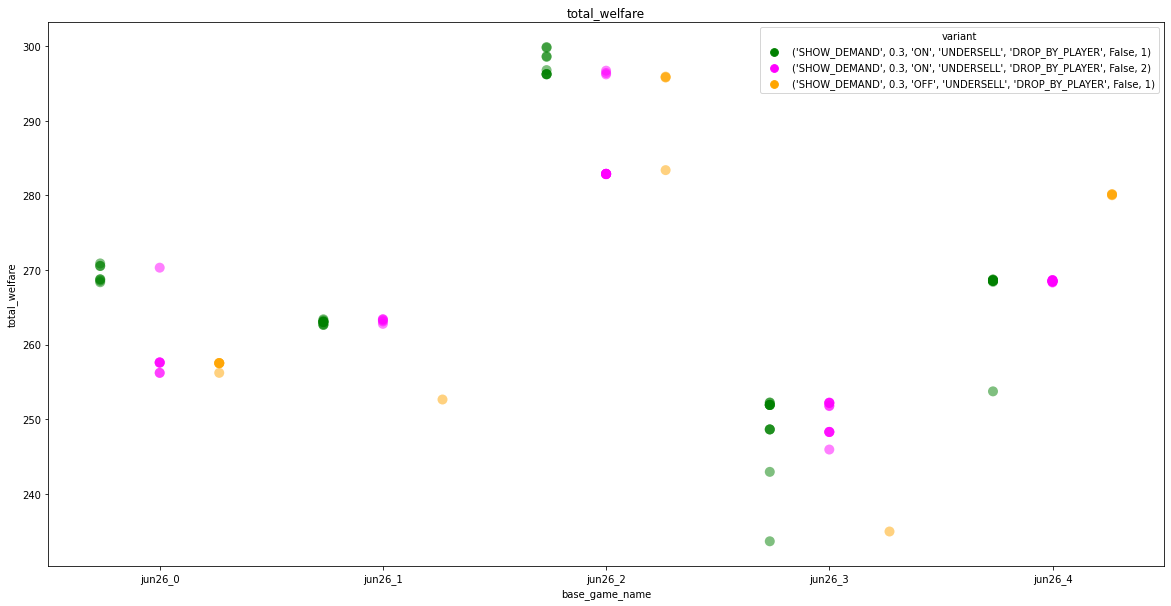

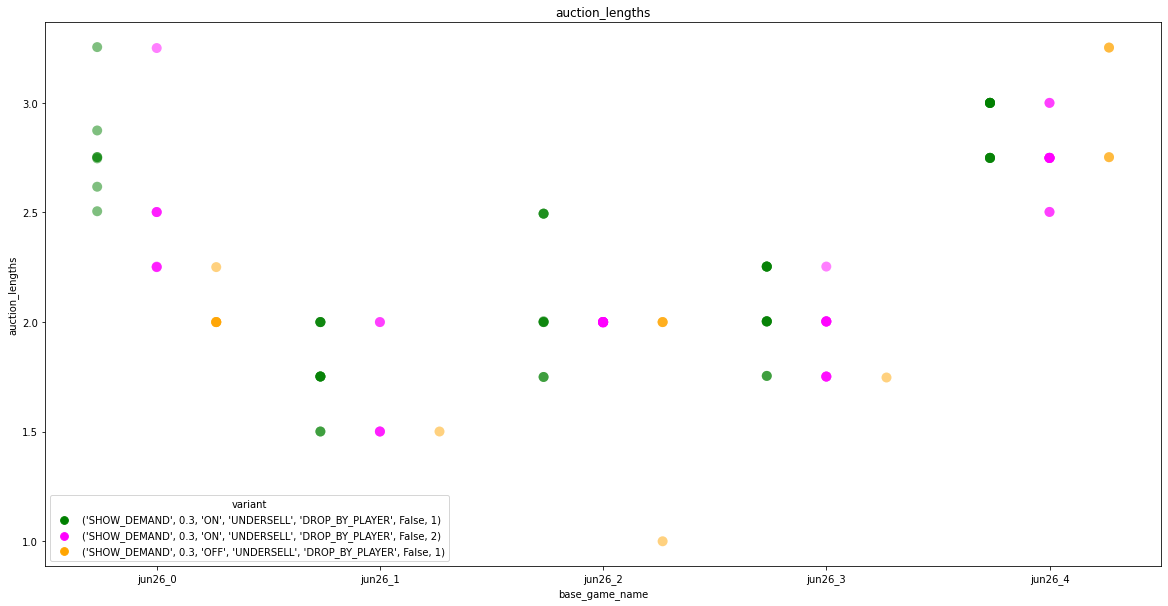

In [130]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df_plt.copy()
markers = ['o', 'X', '^']

# TODO: These strings are getting unwieldy

# Vanilla for clock
CLOCK_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and undersell_policy == "UNDERSELL" and grace_rounds == 1 and tiebreaking_policy == "DROP_BY_PLAYER"'
# box_df = box_df.query(CLOCK_QUERY)

# # Check undersell
UNDERSELL_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(UNDERSELL_QUERY)

# # Check activity
ACTIVITY_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(ACACTIVITY_QUERY)

# # Check tiebreaking
TIEBREAKING_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and grace_rounds == 1'
# box_df = box_df.query(TIEBREAKING_QUERY)

# Check grace
GRACE_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion'
# box_df = box_df.query(GRACE_QUERY)

# Activity ON vs grace vs activity OFF
box_df = box_df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion')


box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

# box_df = box_df.query('alg.str.contains("outcome")')

print(len(box_df))


STATS = ['total_revenue', 'total_welfare', 'auction_lengths']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        sns.stripplot(data=box_df, **strip_kwargs)
        # for i, config in enumerate(box_df['config'].unique()):
        #     # print(config, markers[i])
        #     # TODO: If no entries exist, this pushes colours to the wrong positions
        #     ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
        #     if i == 0:
        #         old_handles, old_labels = ax.get_legend_handles_labels()
        # ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

In [ ]:
df_plt.

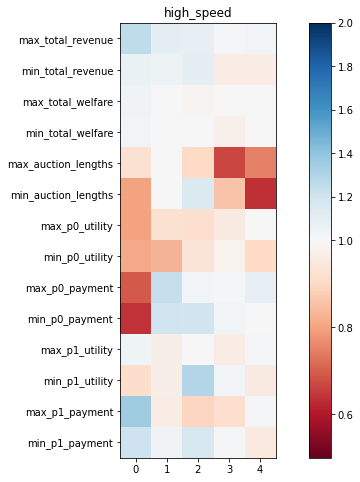

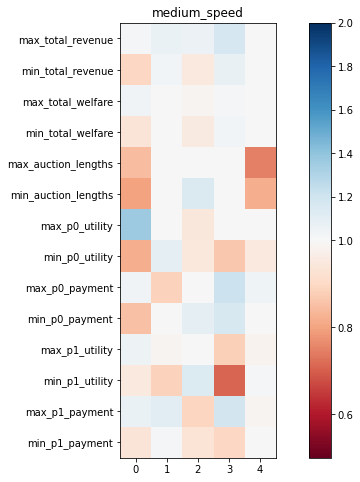

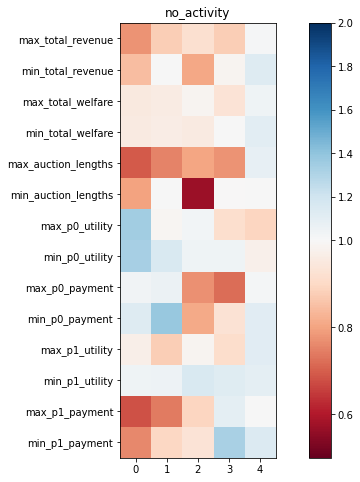

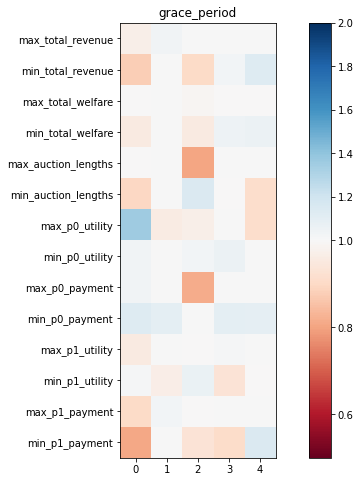

In [155]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']

for query in [CLOCK_QUERY, UNDERSELL_QUERY, ACTIVITY_QUERY, TIEBREAKING_QUERY, GRACE_QUERY]: 
    clock_df = df_plt.query(query)
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].max()
        data[f'min_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].min()

    heatmap_df = pd.DataFrame(data) 
    
    for rule_set in heatmap_df.reset_index()['rule_set'].unique():
        if rule_set != 'base':
            cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2)
            plt.figure(figsize=(12, 8))
            plt.imshow((heatmap_df.loc[rule_set] / heatmap_df.loc['base']).values.T, cmap='RdBu', norm=cmap_norm)
            plt.title(rule_set)
            plt.yticks(range(len(heatmap_df.loc['base'].columns)), heatmap_df.loc['base'].columns)
            plt.colorbar()
            plt.show()


In [148]:
heatmap_df.reset_index()['rule_set'].unique()

array(['base', 'high_speed', 'medium_speed'], dtype=object)

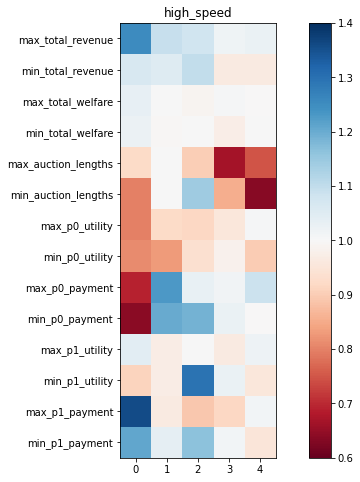

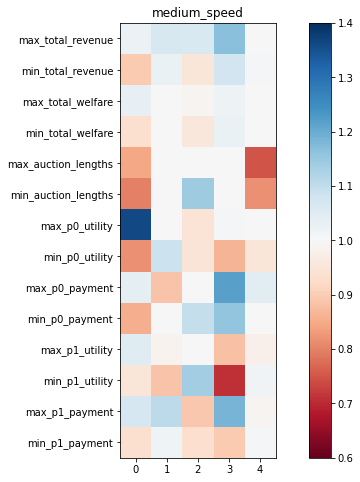

In [151]:
for rule_set in heatmap_df.reset_index()['rule_set'].unique():
    if rule_set != 'base':

        cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.6, vcenter=1, vmax=1.4)
        plt.figure(figsize=(12, 8))
        plt.imshow((heatmap_df.loc[rule_set] / heatmap_df.loc['base']).values.T, cmap='RdBu', norm=cmap_norm)
        plt.title(rule_set)
        plt.yticks(range(len(heatmap_df.loc['base'].columns)), heatmap_df.loc['base'].columns)
        plt.colorbar()
        plt.show()


Index(['game_name', 'potential', 'seed', 'run_name', 'experiment', 'config',
       't', 'information_policy', 'activity_policy', 'undersell_policy',
       'tiebreaking_policy', 'grace_rounds', 'risk_aversion', 'spite',
       'clock_speed', 'base_game_name', 'alg', 'walltime', 'nash_conv',
       'rewards', 'nash_conv_frac', 'heuristic_conv', 'heuristic_conv_frac',
       'rewards_0', 'nc_player_improvements_0',
       'nc_player_improvements_frac_0', 'hc_player_improvements_0',
       'hc_player_improvements_frac_0', 'rewards_1',
       'nc_player_improvements_1', 'nc_player_improvements_frac_1',
       'hc_player_improvements_1', 'hc_player_improvements_frac_1',
       'total_entropy', 'unsold', 'p0_utility', 'p0_payment',
       'p0_total_entropies', 'p1_utility', 'p1_payment', 'p1_total_entropies',
       'total_welfare', 'total_revenue', 'auction_lengths',
       'common_allocations', 'DifferenceConv', 'variant'],
      dtype='object')

In [21]:
df.query('run_name.str.contains("jun26_jun26_4_grace_period-cfr_port_2external_plus-100")')['nash_conv']

Series([], Name: nash_conv, dtype: float64)

In [22]:
df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3')[['nash_conv_frac']]

,nash_conv_frac
0,NaN
1,0.002697
2,NaN
4,0.005431
5,NaN
...,...
185,NaN
187,0.048683
188,0.014213
191,0.004405


In [ ]:


# ### Code to rerun evals for a failed experiment
# from open_spiel.python.examples.ubc_dispatch import dispatch_eval_database
# exp = 'jun5outcome'

# for e in Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp):
#     experiment_name = e.checkpoint.equilibrium_solver_run.experiment.name
#     run_name = e.checkpoint.equilibrium_solver_run.name
#     t = e.checkpoint.t
#     dispatch_eval_database(experiment_name, run_name, t, None, None)
# print(Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp).delete())

In [ ]:
df.query('alg == "PPO"').groupby(['experiment', 'imperfect']).mean()

In [ ]:
# val_df.groupby(['game', 'alg']).describe()
val_df.groupby(['game', 'alg']).describe()

In [ ]:
# import open_spiel.python.examples.ubc_dispatch as dispatch
# for run in runs:
#     try:
#         game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
#     except:
#         print("Skipping", run)
#         continue
#     final_checkpoint.bestresponse_set.all().delete()
#     for player in range(game.num_players()):
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'modal') 
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'tremble')  

In [27]:
### This is the cell you run when you want to rerun evals 
bad_count = 0
overwrite_existing = True
for run in tqdm(runs):
    # print(run)
    try:
        game, final_checkpoint, policy = get_results(run, load_policy=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue

    try:
        ev = final_checkpoint.get_modal_eval()
        if not pd.isnull(ev.nash_conv) and not overwrite_existing:
            continue
        else:
            ev.delete()
    except Exception as e:
        ev = None

    bad_count += 1
    br_mapping = {p: 'modal' for p in range(2)}
    dispatch.dispatch_eval_database(final_checkpoint.t, run.experiment.name, run.name, str(br_mapping))
    
print(bad_count)

  1%|▊                                                                                                                                                                    | 1/195 [00:00<01:35,  2.04it/s]

Submitted batch job 92428


  1%|█▋                                                                                                                                                                   | 2/195 [00:00<01:18,  2.47it/s]

Submitted batch job 92429


  2%|███▍                                                                                                                                                                 | 4/195 [00:01<01:11,  2.66it/s]

Submitted batch job 92430
Submitted batch job 92431


  3%|████▏                                                                                                                                                                | 5/195 [00:01<01:07,  2.81it/s]

Submitted batch job 92432


  3%|█████                                                                                                                                                                | 6/195 [00:02<01:17,  2.44it/s]

Submitted batch job 92433


  4%|█████▉                                                                                                                                                               | 7/195 [00:02<01:11,  2.64it/s]

Submitted batch job 92434


  4%|██████▊                                                                                                                                                              | 8/195 [00:03<01:14,  2.51it/s]

Submitted batch job 92435


  5%|███████▌                                                                                                                                                             | 9/195 [00:03<01:10,  2.63it/s]

Submitted batch job 92436


  6%|█████████▎                                                                                                                                                          | 11/195 [00:04<00:55,  3.34it/s]

Submitted batch job 92437
Submitted batch job 92438


  7%|██████████▉                                                                                                                                                         | 13/195 [00:04<00:57,  3.19it/s]

Submitted batch job 92439
Submitted batch job 92440


  7%|███████████▊                                                                                                                                                        | 14/195 [00:05<01:11,  2.52it/s]

Submitted batch job 92441


  8%|█████████████▍                                                                                                                                                      | 16/195 [00:05<00:56,  3.19it/s]

Submitted batch job 92442
Submitted batch job 92443


  9%|███████████████▏                                                                                                                                                    | 18/195 [00:06<00:49,  3.56it/s]

Submitted batch job 92444
Submitted batch job 92445


 10%|████████████████▊                                                                                                                                                   | 20/195 [00:06<00:43,  3.98it/s]

Submitted batch job 92446
Submitted batch job 92447


 11%|█████████████████▋                                                                                                                                                  | 21/195 [00:07<00:48,  3.62it/s]

Submitted batch job 92448


 12%|███████████████████▎                                                                                                                                                | 23/195 [00:07<00:42,  4.09it/s]

Submitted batch job 92449
Submitted batch job 92450


 12%|████████████████████▏                                                                                                                                               | 24/195 [00:08<00:47,  3.64it/s]

Submitted batch job 92451


 13%|█████████████████████▊                                                                                                                                              | 26/195 [00:08<00:43,  3.85it/s]

Submitted batch job 92452
Submitted batch job 92453


 14%|██████████████████████▋                                                                                                                                             | 27/195 [00:08<00:48,  3.49it/s]

Submitted batch job 92454


 15%|████████████████████████▍                                                                                                                                           | 29/195 [00:09<00:43,  3.83it/s]

Submitted batch job 92455
Submitted batch job 92456


 16%|██████████████████████████                                                                                                                                          | 31/195 [00:09<00:40,  4.08it/s]

Submitted batch job 92457
Submitted batch job 92458


 16%|██████████████████████████▉                                                                                                                                         | 32/195 [00:10<00:44,  3.65it/s]

Submitted batch job 92459


 17%|████████████████████████████▌                                                                                                                                       | 34/195 [00:10<00:39,  4.07it/s]

Submitted batch job 92460
Submitted batch job 92461


 18%|█████████████████████████████▍                                                                                                                                      | 35/195 [00:11<00:43,  3.68it/s]

Submitted batch job 92462


 19%|███████████████████████████████                                                                                                                                     | 37/195 [00:12<01:03,  2.48it/s]

Submitted batch job 92463
Submitted batch job 92464


 19%|███████████████████████████████▉                                                                                                                                    | 38/195 [00:12<00:58,  2.66it/s]

Submitted batch job 92465


 21%|█████████████████████████████████▋                                                                                                                                  | 40/195 [00:13<00:51,  2.98it/s]

Submitted batch job 92466
Submitted batch job 92467


 22%|███████████████████████████████████▎                                                                                                                                | 42/195 [00:13<00:44,  3.44it/s]

Submitted batch job 92468
Submitted batch job 92469


 22%|████████████████████████████████████▏                                                                                                                               | 43/195 [00:14<00:45,  3.33it/s]

Submitted batch job 92470


 23%|█████████████████████████████████████                                                                                                                               | 44/195 [00:14<00:42,  3.57it/s]

Submitted batch job 92471


 23%|█████████████████████████████████████▊                                                                                                                              | 45/195 [00:14<00:46,  3.24it/s]

Submitted batch job 92472


 24%|██████████████████████████████████████▋                                                                                                                             | 46/195 [00:15<00:42,  3.51it/s]

Submitted batch job 92473


 24%|███████████████████████████████████████▌                                                                                                                            | 47/195 [00:15<00:44,  3.36it/s]

Submitted batch job 92474


 25%|████████████████████████████████████████▎                                                                                                                           | 48/195 [00:15<00:48,  3.00it/s]

Submitted batch job 92475


 26%|██████████████████████████████████████████                                                                                                                          | 50/195 [00:16<00:43,  3.30it/s]

Submitted batch job 92476
Submitted batch job 92477


 26%|██████████████████████████████████████████▉                                                                                                                         | 51/195 [00:16<00:43,  3.28it/s]

Submitted batch job 92478


 27%|████████████████████████████████████████████▌                                                                                                                       | 53/195 [00:17<00:43,  3.23it/s]

Submitted batch job 92479
Submitted batch job 92480


 28%|██████████████████████████████████████████████▎                                                                                                                     | 55/195 [00:17<00:35,  3.90it/s]

Submitted batch job 92481
Submitted batch job 92482


 29%|███████████████████████████████████████████████▉                                                                                                                    | 57/195 [00:18<00:36,  3.75it/s]

Submitted batch job 92483
Submitted batch job 92484


 30%|████████████████████████████████████████████████▊                                                                                                                   | 58/195 [00:18<00:46,  2.97it/s]

Submitted batch job 92485


 30%|█████████████████████████████████████████████████▌                                                                                                                  | 59/195 [00:19<00:45,  3.01it/s]

Submitted batch job 92486


 31%|██████████████████████████████████████████████████▍                                                                                                                 | 60/195 [00:19<00:49,  2.72it/s]

Submitted batch job 92487


 31%|███████████████████████████████████████████████████▎                                                                                                                | 61/195 [00:20<00:47,  2.82it/s]

Submitted batch job 92488


 32%|████████████████████████████████████████████████████▏                                                                                                               | 62/195 [00:20<00:51,  2.58it/s]

Submitted batch job 92489


 33%|█████████████████████████████████████████████████████▊                                                                                                              | 64/195 [00:20<00:39,  3.29it/s]

Submitted batch job 92490
Submitted batch job 92491


 34%|███████████████████████████████████████████████████████▌                                                                                                            | 66/195 [00:21<00:33,  3.89it/s]

Submitted batch job 92492
Submitted batch job 92493


 35%|█████████████████████████████████████████████████████████▏                                                                                                          | 68/195 [00:21<00:29,  4.37it/s]

Submitted batch job 92494
Submitted batch job 92495


 36%|██████████████████████████████████████████████████████████▊                                                                                                         | 70/195 [00:22<00:28,  4.44it/s]

Submitted batch job 92496
Submitted batch job 92497


 36%|███████████████████████████████████████████████████████████▋                                                                                                        | 71/195 [00:22<00:31,  3.93it/s]

Submitted batch job 92498


 37%|█████████████████████████████████████████████████████████████▍                                                                                                      | 73/195 [00:23<00:34,  3.58it/s]

Submitted batch job 92499
Submitted batch job 92500


 38%|███████████████████████████████████████████████████████████████                                                                                                     | 75/195 [00:23<00:30,  3.95it/s]

Submitted batch job 92501
Submitted batch job 92502


 39%|████████████████████████████████████████████████████████████████▊                                                                                                   | 77/195 [00:24<00:27,  4.31it/s]

Submitted batch job 92503
Submitted batch job 92504


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 78/195 [00:24<00:36,  3.19it/s]

Submitted batch job 92505


 41%|██████████████████████████████████████████████████████████████████▍                                                                                                 | 79/195 [00:25<00:32,  3.57it/s]

Submitted batch job 92506


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                | 80/195 [00:25<00:46,  2.49it/s]

Submitted batch job 92507


 42%|████████████████████████████████████████████████████████████████████                                                                                                | 81/195 [00:26<00:43,  2.64it/s]

Submitted batch job 92508


 42%|████████████████████████████████████████████████████████████████████▉                                                                                               | 82/195 [00:26<00:45,  2.47it/s]

Submitted batch job 92509


 43%|█████████████████████████████████████████████████████████████████████▊                                                                                              | 83/195 [00:26<00:42,  2.61it/s]

Submitted batch job 92510


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                             | 84/195 [00:27<00:59,  1.87it/s]

Submitted batch job 92511


 44%|███████████████████████████████████████████████████████████████████████▍                                                                                            | 85/195 [00:28<00:51,  2.13it/s]

Submitted batch job 92512


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                           | 86/195 [00:28<01:00,  1.81it/s]

Submitted batch job 92513


 45%|██████████████████████████████████████████████████████████████████████████                                                                                          | 88/195 [00:29<00:41,  2.57it/s]

Submitted batch job 92514
Submitted batch job 92515


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                        | 90/195 [00:29<00:30,  3.44it/s]

Submitted batch job 92516
Submitted batch job 92517


 47%|████████████████████████████████████████████████████████████████████████████▌                                                                                       | 91/195 [00:30<00:39,  2.65it/s]

Submitted batch job 92518


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                      | 92/195 [00:30<00:39,  2.63it/s]

Submitted batch job 92519


 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                     | 93/195 [00:31<00:39,  2.60it/s]

Submitted batch job 92520


 49%|███████████████████████████████████████████████████████████████████████████████▉                                                                                    | 95/195 [00:31<00:30,  3.27it/s]

Submitted batch job 92521
Submitted batch job 92522


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 96/195 [00:32<00:37,  2.64it/s]

Submitted batch job 92523


 50%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 97/195 [00:32<00:35,  2.77it/s]

Submitted batch job 92524


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                | 99/195 [00:33<00:30,  3.13it/s]

Submitted batch job 92525
Submitted batch job 92526


 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                               | 100/195 [00:33<00:31,  3.03it/s]

Submitted batch job 92527


 52%|████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 101/195 [00:33<00:32,  2.89it/s]

Submitted batch job 92528


 53%|██████████████████████████████████████████████████████████████████████████████████████                                                                             | 103/195 [00:34<00:26,  3.45it/s]

Submitted batch job 92529
Submitted batch job 92530


 54%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 105/195 [00:34<00:24,  3.72it/s]

Submitted batch job 92531
Submitted batch job 92532


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 106/195 [00:35<00:29,  3.01it/s]

Submitted batch job 92533


 55%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 107/195 [00:35<00:28,  3.09it/s]

Submitted batch job 92534


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 108/195 [00:36<00:52,  1.65it/s]

Submitted batch job 92535


 56%|███████████████████████████████████████████████████████████████████████████████████████████                                                                        | 109/195 [00:37<01:01,  1.40it/s]

Submitted batch job 92536


 56%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 110/195 [00:38<00:51,  1.66it/s]

Submitted batch job 92537


 57%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 111/195 [00:38<00:44,  1.87it/s]

Submitted batch job 92538


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 112/195 [00:39<00:45,  1.83it/s]

Submitted batch job 92539


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 113/195 [00:39<00:39,  2.10it/s]

Submitted batch job 92540


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 114/195 [00:39<00:34,  2.32it/s]

Submitted batch job 92541


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 115/195 [00:40<00:37,  2.15it/s]

Submitted batch job 92542


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 117/195 [00:40<00:26,  2.98it/s]

Submitted batch job 92543
Submitted batch job 92544


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 118/195 [00:41<00:25,  3.03it/s]

Submitted batch job 92545


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 120/195 [00:41<00:21,  3.49it/s]

Submitted batch job 92546
Submitted batch job 92547


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 121/195 [00:41<00:22,  3.34it/s]

Submitted batch job 92548


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 122/195 [00:42<00:30,  2.43it/s]

Submitted batch job 92549


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 124/195 [00:43<00:21,  3.26it/s]

Submitted batch job 92550
Submitted batch job 92551


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 126/195 [00:43<00:17,  3.93it/s]

Submitted batch job 92552
Submitted batch job 92553


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 128/195 [00:43<00:15,  4.43it/s]

Submitted batch job 92554
Submitted batch job 92555


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 130/195 [00:44<00:14,  4.59it/s]

Submitted batch job 92556
Submitted batch job 92557


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 132/195 [00:44<00:15,  4.17it/s]

Submitted batch job 92558
Submitted batch job 92559


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 133/195 [00:45<00:16,  3.79it/s]

Submitted batch job 92560


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 135/195 [00:45<00:14,  4.22it/s]

Submitted batch job 92561
Submitted batch job 92562


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 137/195 [00:46<00:13,  4.37it/s]

Submitted batch job 92563
Submitted batch job 92564


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 139/195 [00:46<00:12,  4.53it/s]

Submitted batch job 92565
Submitted batch job 92566


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 140/195 [00:47<00:13,  3.99it/s]

Submitted batch job 92567


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 142/195 [00:47<00:14,  3.61it/s]

Submitted batch job 92568
Submitted batch job 92569


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 143/195 [00:48<00:15,  3.32it/s]

Submitted batch job 92570


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 144/195 [00:48<00:13,  3.67it/s]

Submitted batch job 92571


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 145/195 [00:48<00:16,  3.10it/s]

Submitted batch job 92572


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 146/195 [00:48<00:14,  3.35it/s]

Submitted batch job 92573


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 148/195 [00:49<00:13,  3.59it/s]

Submitted batch job 92574
Submitted batch job 92575


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 149/195 [00:49<00:13,  3.33it/s]

Submitted batch job 92576


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 151/195 [00:50<00:11,  3.89it/s]

Submitted batch job 92577
Submitted batch job 92578


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 153/195 [00:50<00:09,  4.20it/s]

Submitted batch job 92579
Submitted batch job 92580


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 154/195 [00:51<00:10,  3.83it/s]

Submitted batch job 92581


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 156/195 [00:51<00:09,  4.25it/s]

Submitted batch job 92582
Submitted batch job 92583


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 158/195 [00:52<00:08,  4.42it/s]

Submitted batch job 92584
Submitted batch job 92585


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 160/195 [00:52<00:07,  4.67it/s]

Submitted batch job 92586
Submitted batch job 92587


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 161/195 [00:52<00:09,  3.45it/s]

Submitted batch job 92588


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 162/195 [00:53<00:09,  3.61it/s]

Submitted batch job 92589


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 163/195 [00:53<00:09,  3.40it/s]

Submitted batch job 92590


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 164/195 [00:53<00:09,  3.40it/s]

Submitted batch job 92591


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 166/195 [00:54<00:07,  4.07it/s]

Submitted batch job 92592
Submitted batch job 92593


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 167/195 [00:54<00:07,  3.77it/s]

Submitted batch job 92594


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 169/195 [00:55<00:06,  4.20it/s]

Submitted batch job 92595
Submitted batch job 92596


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 171/195 [00:55<00:05,  4.47it/s]

Submitted batch job 92597
Submitted batch job 92598


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 172/195 [00:55<00:05,  3.87it/s]

Submitted batch job 92599


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 174/195 [00:56<00:04,  4.22it/s]

Submitted batch job 92600
Submitted batch job 92601


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 175/195 [00:56<00:05,  3.84it/s]

Submitted batch job 92602


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 176/195 [00:56<00:04,  3.88it/s]

Submitted batch job 92603


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 177/195 [00:57<00:05,  3.55it/s]

Submitted batch job 92604


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 179/195 [00:57<00:04,  3.72it/s]

Submitted batch job 92605
Submitted batch job 92606


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 180/195 [00:58<00:04,  3.55it/s]

Submitted batch job 92607


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 181/195 [00:58<00:04,  3.41it/s]

Submitted batch job 92608


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 182/195 [00:58<00:03,  3.69it/s]

Submitted batch job 92609


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 183/195 [00:58<00:03,  3.52it/s]

Submitted batch job 92610


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 185/195 [00:59<00:02,  3.83it/s]

Submitted batch job 92611
Submitted batch job 92612


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 186/195 [00:59<00:02,  3.52it/s]

Submitted batch job 92613


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 187/195 [01:00<00:02,  3.23it/s]

Submitted batch job 92614


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 188/195 [01:00<00:01,  3.55it/s]

Submitted batch job 92615


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 190/195 [01:00<00:01,  3.87it/s]

Submitted batch job 92616
Submitted batch job 92617


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 191/195 [01:01<00:01,  3.65it/s]

Submitted batch job 92618


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 192/195 [01:01<00:00,  3.38it/s]

Submitted batch job 92619


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 193/195 [01:01<00:00,  3.67it/s]

Submitted batch job 92620


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [01:02<00:00,  3.13it/s]

Submitted batch job 92621
Submitted batch job 92622
195


In [ ]:
game = pyspiel.load_game('python_clock_auction')